## Test Phase

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/COMP6471-IS"

In [ ]:
# #changing the working directory
# %cd /content/gdrive/My Drive/COMP6471-IS
# #Check the present working directory using pwd command

/content/gdrive/My Drive/COMP6471-IS


In [ ]:
# Download dataset from https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
#!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
# download cifar dataset for non-human object
#!kaggle datasets download -d swaroopkml/cifar10-pngs-in-folders
# https://course.fast.ai/datasets#image-classification

#### importing all the necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from tqdm import tqdm
from statistics import mean
import pandas as pd


In [ ]:
# pytorch packages
import torch
from torchvision import datasets, models, transforms, utils
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
# TO enable GPU. GO to runtime and change runtime type  to 'GPU'. if cuda the GPU is used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda


In [ ]:
#!unzip FaceMaskDataset.zip -d dataset
# !unzip small.zip -d small
# !unzip small/Validation/Validation.zip -d temp

# !unzip Male.zip -d male-test-set
# !unzip Female.zip -d female-test-set


## Load the Data, Data pre-processing and Data Augmentation

1.   Normalization of all train, test, and validation dataset
2.   Augmentation of Train dataset only.

  1.   rescale all the image to 28x28
  2.   rotate, crop, shear the images





In [ ]:
# training_path = 'dataset/Train'
# valid_path = 'dataset/Validation'
# test_path = 'dataset/Test'

data_dir_male = 'male-test-set'
data_dir_female = 'female-test-set'
# data_dir = 'small'

In [ ]:


#### Somaye Transformation
data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


image_datasets_male = datasets.ImageFolder(data_dir_male, data_transforms)
image_datasets_female = datasets.ImageFolder(data_dir_female, data_transforms)

dataloaders_male = torch.utils.data.DataLoader(image_datasets_male, batch_size=4,
                                             shuffle=True, num_workers=2)
dataloaders_female = torch.utils.data.DataLoader(image_datasets_female, batch_size=4,
                                             shuffle=True, num_workers=2)
dataset_sizes_male =  len(image_datasets_male)
dataset_sizes_female =  len(image_datasets_female)
class_names_male = image_datasets_male.classes
class_names_female = image_datasets_female.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


inputs_male, classes_male = next(iter(dataloaders_male))
inputs_female, classes_female = next(iter(dataloaders_female))
print("male dataset:")
print("   ",inputs_male.shape)
print("   ",class_names_male)
print("\nfemale dataset:")
print("   ",inputs_female.shape)
print("   ",class_names_female)


male dataset:
    torch.Size([4, 3, 224, 224])
    ['NonHuman', 'WithMask', 'WithoutMask']

female dataset:
    torch.Size([4, 3, 224, 224])
    ['NonHuman', 'WithMask', 'WithoutMask']


100%|██████████| 2/2 [00:00<00:00, 1064.95it/s]


samples of male dataset:


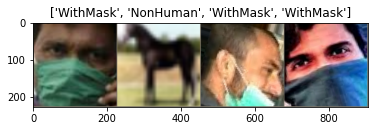

samples of female dataset:


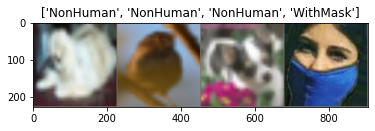

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs_male, classes_male = tqdm(next(iter(dataloaders_male)))
inputs_female, classes_female = tqdm(next(iter(dataloaders_female)))

# Make a grid from batch
print("samples of male dataset:")
out_male = utils.make_grid(inputs_male)
imshow(out_male, title=[class_names_male[x] for x in classes_male])

print("samples of female dataset:")
out_female = utils.make_grid(inputs_female)
imshow(out_female, title=[class_names_female[x] for x in classes_female])

In [ ]:

def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()

In [ ]:
def show_img(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (3,3))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

def test(test_loader, model):
    losses = []
    accs = []
    accs_plot = []
    losses_plot = []
    output_labels = np.array([])
    test_labels = np.array([])
    false_prediction_img = []
    false_prediction_label = []
    counter = 0
    model.eval()
    
    for i, (images, target) in enumerate(tqdm(test_loader, position=0, leave=True)):
 
        images, target = images.to(device), target.to(device)
        test_labels = np.append(test_labels, target.cpu().detach().numpy())

        # compute output
        output = model(images)
        prediction = output.argmax(1)
        tmp = prediction.cpu().detach().numpy()
        output_labels = np.append(output_labels, tmp)
        # loss = criterion(output, target)
        
        # measure accuracy and record loss
        loss = torch.nn.functional.cross_entropy(output, target)
        
        acc = accuracy(output, target)
        losses.append(loss.item())
        accs.append(acc.item())
        if i%50 == 0:
          accs_plot.append(acc.item())
          losses_plot.append(loss.item())
        if counter < 3:
          if tmp!=target :
            i = 0
            for x in target:
              if x != tmp[i]:
                false_prediction_img.append(images[i])
                false_prediction_label.append('label"'+class_names_male[x]+' predicted"'+class_names_male[tmp[i]])
                counter +=1
              i +=1



    return losses, accs, output_labels, accs_plot, losses_plot, test_labels, false_prediction_img,  false_prediction_label
    # return losses, accs
      

###  Model definition

In [ ]:
class block(nn.Module):
    def __init__(self, filters, subsample = False):
        super().__init__()
        
        s = 0.5 if subsample else 1.0

        # layers
        self.conv1 = nn.Conv2d(int(filters*s), filters, kernel_size=3, 
                               stride=int(1/s), padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu2 = nn.ReLU()
        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)   
        
    
    def forward(self, x):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu1(z)
        
        z = self.conv2(z)
        z = self.bn2(z)
        
        # shortcut connection
        if x.shape != z.shape:
            d = self.downsample(x)
            p = torch.mul(d, 0)
            z = z + torch.cat((d, p), dim=1)
        else:
            z = z + x 

        z = self.relu2(z)
        
        return z



class myModel(nn.Module):
    def __init__(self, n):
        super().__init__()
        
        # first layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64, track_running_stats=True)
        self.relu   = nn.ReLU()
        
        # blocks
        self.block1 = nn.ModuleList([block(64, subsample=False) for _ in range(n)])

        # to speed up the computation
        # self.block21 = block(128, subsample=True)
        # self.block22 = nn.ModuleList([block(128, subsample=False) for _ in range(n-1)])

        # self.block31 = block(256, subsample=True)
        # self.block32 = nn.ModuleList([block(256, subsample=False) for _ in range(n-1)])
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.softmax = nn.LogSoftmax(dim=-1)

        # to speed up the computation
        # self.classifier = nn.Sequential(
        #     nn.Dropout(),
        #     nn.Linear(256 , 512),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(512, 3),
        # )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 , 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3),
        )

        
        # initilise weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()      
        
        
    def forward(self, x):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu(z)

        for l in self.block1: z = l(z)

        # to speed up the computation
        # z = self.block21(z)
        # for l in self.block22: 
        #     z = l(z)

        # z = self.block31(z)
        # for l in self.block32: 
        #     z = l(z)

        z = self.avgpool(z)
        z = z.view(z.size(0), -1)
        z = self.classifier(z)
        return self.softmax(z)

In [ ]:
%%time


#Loading Trained Model
# PATH = "SavedModel_BeforeBalancing.pt"
NAME = "bias_before_balancing_sm"
PATH = NAME+".pt"

new_model = myModel(2)
new_model = new_model.to(device)


new_model.load_state_dict(torch.load(PATH))
new_model.eval()



CPU times: user 2.27 s, sys: 1.13 s, total: 3.4 s
Wall time: 11.1 s


  0%|          | 0/113 [00:00<?, ?it/s]


Male Test Phase


100%|██████████| 113/113 [01:03<00:00,  1.78it/s]

   mean of losses: 0.6179919500662162
   mean of accuracies: 0.7433628318584071
   some samples of wrong prediction:


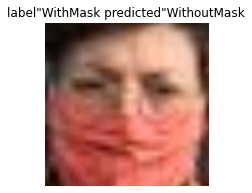

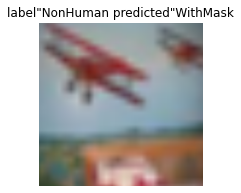

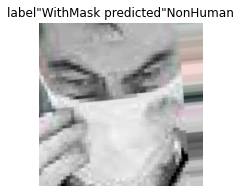

In [ ]:
print("\nMale Test Phase")
losses_model_new_male, accs_model_new_male, predicted_labels_test_new_male, accs_plot_model_new_male,\
 losses_plot_model_new_male, test_labels_new_male, false_prediction_img_male, false_prediction_label_male\
  = test(dataloaders_male, new_model)

Accuracy_model_new_male = str(round(mean(accs_model_new_male)*100, 2))
# print("   losses",losses)
print("   mean of losses:", mean(losses_model_new_male))
# print("   accs",accs)
print("   mean of accuracies:", mean(accs_model_new_male))

print("   some samples of wrong prediction:")
i=0
for img in false_prediction_img_male:
  show_img(img, false_prediction_label_male[i])
  i+=1

  0%|          | 0/113 [00:00<?, ?it/s]


Female Test Phase


100%|██████████| 113/113 [01:02<00:00,  1.81it/s]

   mean of losses: 0.5819019106241454
   mean of accuracies: 0.7676991150442478
   some samples of wrong prediction:


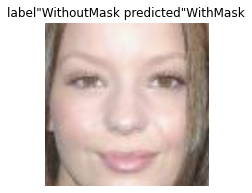

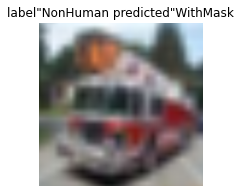

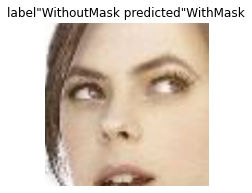

In [ ]:
print("\nFemale Test Phase")
losses_model_new_female, accs_model_new_female, predicted_labels_test_new_female, accs_plot_model_new_female,\
 losses_plot_model_new_female, test_labels_new_female, false_prediction_img_female, false_prediction_label_female\
  = test(dataloaders_female, new_model)

Accuracy_model_new_female = str(round(mean(accs_model_new_female)*100, 2))
# print("   losses",losses)
print("   mean of losses:", mean(losses_model_new_female))
# print("   accs",accs)
print("   mean of accuracies:", mean(accs_model_new_female))

print("   some samples of wrong prediction:")
i=0
for img in false_prediction_img_female:
  show_img(img, false_prediction_label_female[i])
  i+=1

# **Evaluation**
Evaluatig the model in terms of accuracy, precision, recall and F1-measure

In [ ]:
# Train True Labels
# train_labels = np.array([])
# for data,target in dataloaders_male['Train']:
#     train_labels = np.append(train_labels, target.detach().numpy())

# print("Shape of train labels: " + str(train_labels.shape))
# print("Shape of train predicted labels: " + str(predicted_labels_train.shape))
# print("Shape of train predicted labels of AlexNet: " + str(predicted_labels_train_alex.shape))

# Test True Labels
# test_labels = np.array([])
# for data,target in dataloaders_male:
#    test_labels = np.append(test_labels, target.detach().numpy())
print("Shape of male test labels: " + str(test_labels_new_male.shape))
print("Shape of male test predicted labels: " + str(predicted_labels_test_new_male.shape))
# print("Shape of test predicted labels of AlexNet: " + str(predicted_labels_test_alex.shape))
print("\nShape of female test labels: " + str(test_labels_new_female.shape))
print("Shape of female test predicted labels: " + str(predicted_labels_test_new_female.shape))

Shape of male test labels: (450,)
Shape of male test predicted labels: (450,)

Shape of female test labels: (450,)
Shape of female test predicted labels: (450,)


### **Visulaizing accuracy and loss**

Text(0, 0.5, 'accuracy')

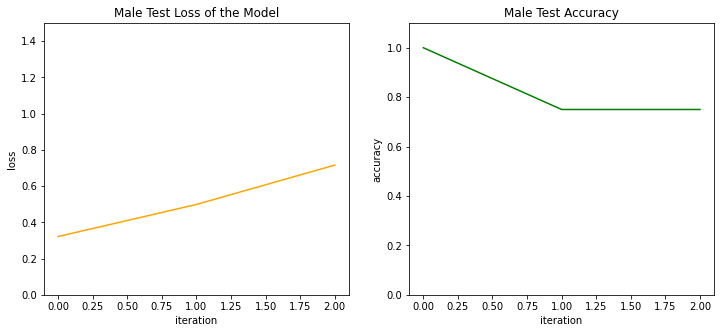

In [ ]:
# our Model
fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].set_ylim([0, 1.5])
axs[0].plot(losses_plot_model_new_male, color='orange')
axs[0].set_title('Male Test Loss of the Model')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[1].set_ylim([0, 1.1])
axs[1].plot(accs_plot_model_new_male, color='green')
axs[1].set_title('Male Test Accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')


Text(0, 0.5, 'accuracy')

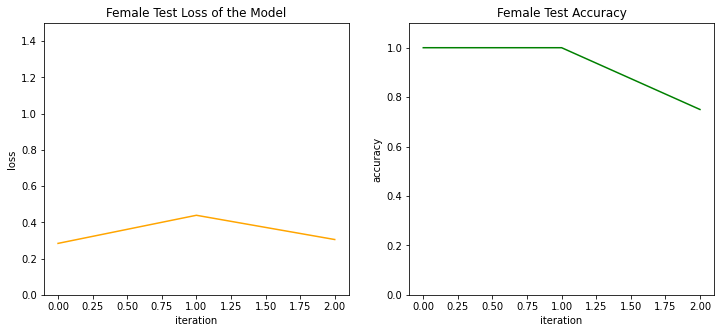

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].set_ylim([0, 1.5])
axs[0].plot(losses_plot_model_new_female, color='orange')
axs[0].set_title('Female Test Loss of the Model')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[1].set_ylim([0, 1.1])
axs[1].plot(accs_plot_model_new_female, color='green')
axs[1].set_title('Female Test Accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')

### **Confusion Matrix** 

''

<Figure size 1080x864 with 0 Axes>

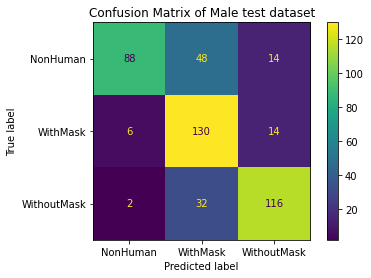

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(15,12))
cnf_test = confusion_matrix(test_labels_new_male, predicted_labels_test_new_male)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cnf_test, display_labels=class_names_male)
disp_test.plot(values_format='') 
plt.title("Confusion Matrix of Male test dataset")


;

''

<Figure size 1080x864 with 0 Axes>

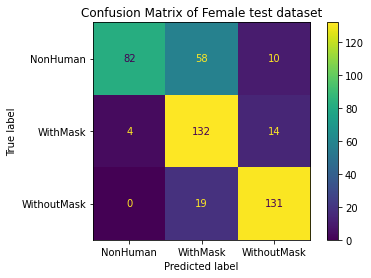

In [ ]:
plt.figure(figsize=(15,12))
cnf_test = confusion_matrix(test_labels_new_female, predicted_labels_test_new_female)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cnf_test, display_labels=class_names_female)
disp_test.plot(values_format='') 
plt.title("Confusion Matrix of Female test dataset")


;

### **Precision and Recall**

In [ ]:
from sklearn.metrics import precision_score, recall_score

ytest_male = test_labels_new_male
ypred_male = predicted_labels_test_new_male

# precision of our model
precision_micro_male = precision_score(ytest_male, ypred_male, average='micro')
precision_macro_male = precision_score(ytest_male, ypred_male, average='macro')

# recall of our model
recall_micro_male = recall_score(ytest_male, ypred_male, average='micro')
recall_macro_male = recall_score(ytest_male, ypred_male, average='macro')

print("------------------ Male Precision and Recal ----------------")
print("Male Precision Micro = " + str(round(precision_micro_male*100, 2)) + "%")
print("Male Precision Macro = " + str(round(precision_macro_male*100, 2))+ "%")
print("Male Recall Micro = " + str(round(recall_micro_male*100, 2))+ "%")
print("Male Recall Macro = " + str(round(recall_macro_male*100, 2))+ "%")


------------------ Male Precision and Recal ----------------
Male Precision Micro = 74.22%
Male Precision Macro = 78.04%
Male Recall Micro = 74.22%
Male Recall Macro = 74.22%


In [ ]:
ytest_female = test_labels_new_female
ypred_female = predicted_labels_test_new_female

# precision of our model
precision_micro_female = precision_score(ytest_female, ypred_female, average='micro')
precision_macro_female = precision_score(ytest_female, ypred_female, average='macro')

# recall of our model
recall_micro_female = recall_score(ytest_female, ypred_female, average='micro')
recall_macro_female = recall_score(ytest_female, ypred_female, average='macro')

print("------------------ Female Precision and Recal ----------------")
print("Female Precision Micro = " + str(round(precision_micro_female*100, 2)) + "%")
print("Female Precision Macro = " + str(round(precision_macro_female*100, 2))+ "%")
print("Female Recall Micro = " + str(round(recall_micro_female*100, 2))+ "%")
print("Female Recall Macro = " + str(round(recall_macro_female*100, 2))+ "%")


------------------ Female Precision and Recal ----------------
Female Precision Micro = 76.67%
Female Precision Macro = 81.01%
Female Recall Micro = 76.67%
Female Recall Macro = 76.67%


### **F1 Score**

In [ ]:
from sklearn.metrics import f1_score


ytest_male = test_labels_new_male
ypred_male = predicted_labels_test_new_male

# F1 Score of our model
f1_micro_male = f1_score(ytest_male, ypred_male, average='micro')
f1_macro_male = f1_score(ytest_male, ypred_male, average='macro')


print("------------------ Male F1 Score ----------------")
print("Male F1 Score Micro = " + str(round(f1_micro_male*100, 2))+ "%")
print("Male F1 Score Macro = " + str(round(f1_macro_male*100, 2))+ "%")


ytest_female = test_labels_new_female
ypred_female = predicted_labels_test_new_female

# F1 Score of our model
f1_micro_female = f1_score(ytest_female, ypred_female, average='micro')
f1_macro_female = f1_score(ytest_female, ypred_female, average='macro')


print("\n------------------ Female F1 Score ----------------")
print("Female F1 Score Micro = " + str(round(f1_micro_female*100, 2))+ "%")
print("Female F1 Score Macro = " + str(round(f1_macro_female*100, 2))+ "%")


------------------ Male F1 Score ----------------
Male F1 Score Micro = 74.22%
Male F1 Score Macro = 74.23%

------------------ Female F1 Score ----------------
Female F1 Score Micro = 76.67%
Female F1 Score Macro = 76.31%


### **Overview of the results**

In [ ]:
pd_data = {'Dataset': [], 
           'Accuracy': [], 
           'Precision_micro': [], 
           'Precision_macro': [], 
           'Recall_micro': [], 
           'Recall_macro': [],
           'F1_micro': [], 
           'F1_macro': []}
df = pd.DataFrame(pd_data)

new_row1 = {'Dataset': 'Male', 
           'Accuracy':Accuracy_model_new_male, 
           'Precision_micro':precision_micro_male, 
           'Precision_macro':precision_macro_male, 
           'Recall_micro':recall_micro_male, 
           'Recall_macro':recall_macro_male,
           'F1_micro': f1_micro_male, 
           'F1_macro': f1_macro_male}

new_row2 = {'Dataset': 'Female', 
           'Accuracy':Accuracy_model_new_female, 
           'Precision_micro':precision_micro_female, 
           'Precision_macro':precision_macro_female, 
           'Recall_micro':recall_micro_female, 
           'Recall_macro':recall_macro_female,
           'F1_micro': f1_micro_female, 
           'F1_macro': f1_macro_female}

df = df.append(new_row1, ignore_index=True)           
df = df.append(new_row2, ignore_index=True)
csv_file = NAME+'_MaleFemaleResults.csv'
df.to_csv(csv_file)
df


,Dataset,Accuracy,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro
0,Male,74.34,0.742222,0.780423,0.742222,0.742222,0.742222,0.742262
1,Female,76.77,0.766667,0.810076,0.766667,0.766667,0.766667,0.763103
